# Exploring 3D ROCurves

Traditionally ROC curves are 2D - signal and background. But our MVA currently has three variables. What can we do in order to understand the ROC curves for that sort of a situation?

## Initalization

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14) # Font size for titles and axes, default is 10
from mpl_toolkits.mplot3d import Axes3D # if this isn't done then the 3d projection isn't known. Aweful UI!
from sklearn.metrics import roc_curve, auc

## Loading Data

Data is stored in a directory somewhere on the server machine. So this is not likely to be portable.
The job number is also kept seperate to make it easy to update everything.

In [2]:
data_location = "..\\..\\MCAResultsData"
jenkins_build = "AllJets"

In [3]:
signal_sample_names=["125pi25lt5m", "200pi25lt5m", "400pi50lt5m", "600pi150lt5m", "1000pi400lt5m"]
bib_sample_names=["data15", "data16"]
mj_sample_names=["jz"]

Next, actual loading of the data. If a file isn't there, we don't really care.

In [4]:
def load_mva_data(sample_name):
    """Load the data written out by a MVA training job into an np array.
    Returns null if the csv file can't be found.
    
    Args:
      sample_name: The name of the sample, e.g. data15
    """
    p = "{0}\\{1}\\all-{2}.csv".format(data_location, jenkins_build, sample_name)
    if not os.path.exists(p):
        return None
    return pd.read_csv(p)

def load_mva_data_from_list(lst):
    """Load data for a series of samples. Silently ignore those we can't find
    
    Args:
        lst: List of samples to load
    """
    return {s[0] : s[1] for s in [(sname, load_mva_data(sname)) for sname in lst] if not(s[1] is None)}

In [5]:
signal_samples = load_mva_data_from_list(signal_sample_names)
bib_samples = load_mva_data_from_list(bib_sample_names)
mj_samples = load_mva_data_from_list(mj_sample_names)

## Basic Plots

Make some basic plots of the weights for each simple individually.

In [6]:
def plot_mva_sample(sample_name, sample_data):
    """Plot the HSS, BIB, and MJ all on one plot as a histogram
    
    Args:
      sample_data: The DataFrame that contains the data for this sample
    """
    nbins = 100
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    plt.hist([sample_data['HSSWeight'], sample_data["MultijetWeight"], sample_data["BIBWeight"]],
             weights=[sample_data.Weight, sample_data.Weight, sample_data.Weight],
             bins=nbins,
             histtype = 'step', normed=True,
             color=['red', 'blue', 'green'],
             label=['HSS Weight', 'Multijet Weight', 'BIB Weight'])
    plt.title("BDT Weights for Sample {0}".format(sample_name))
    plt.xlabel('MVA Weight')
    plt.legend()
    ax.set_yscale('log')
    
def plot_mva_samples(dict_of_samples):
    for k in dict_of_samples.keys():
        plot_mva_sample(k, dict_of_samples[k])
        plt.show()

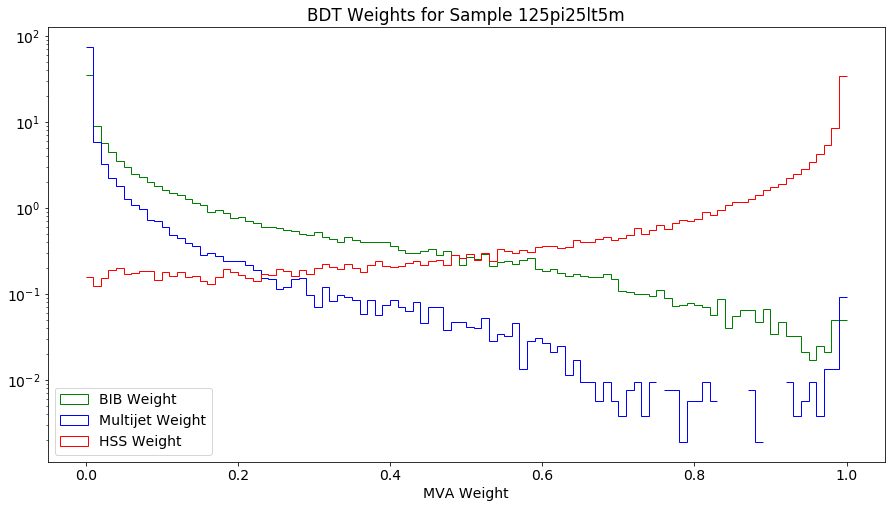

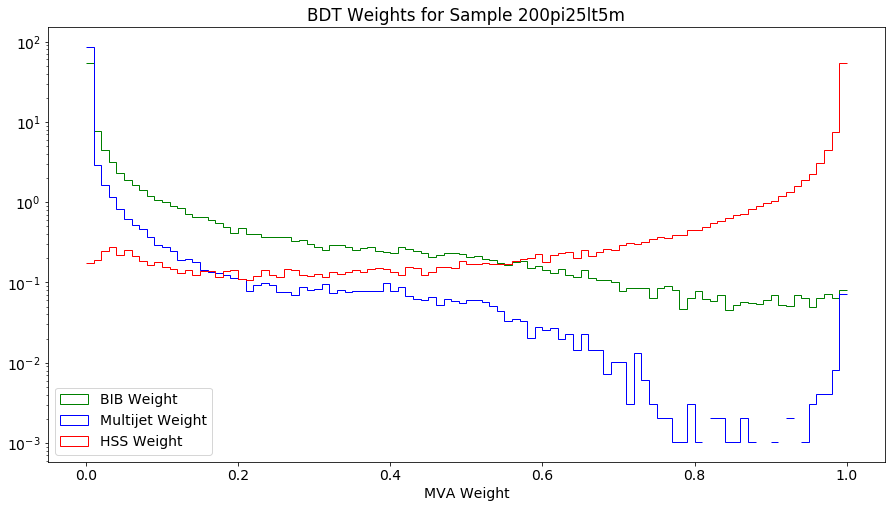

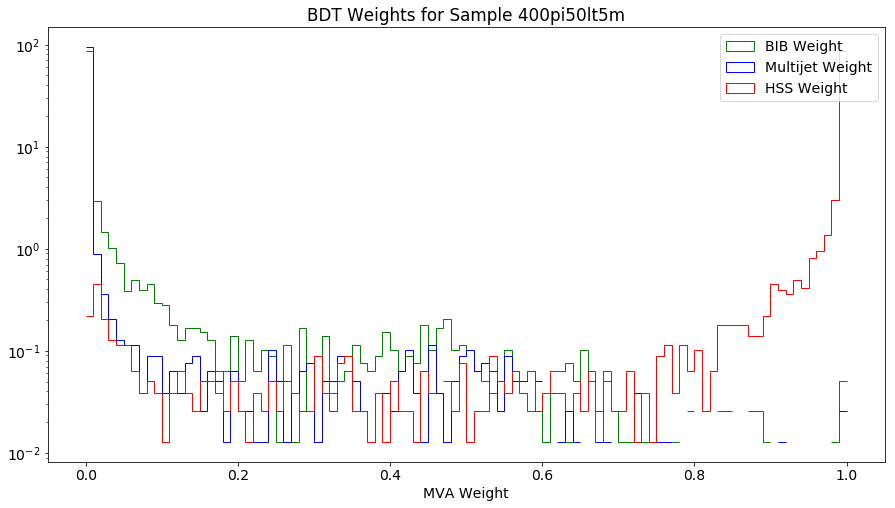

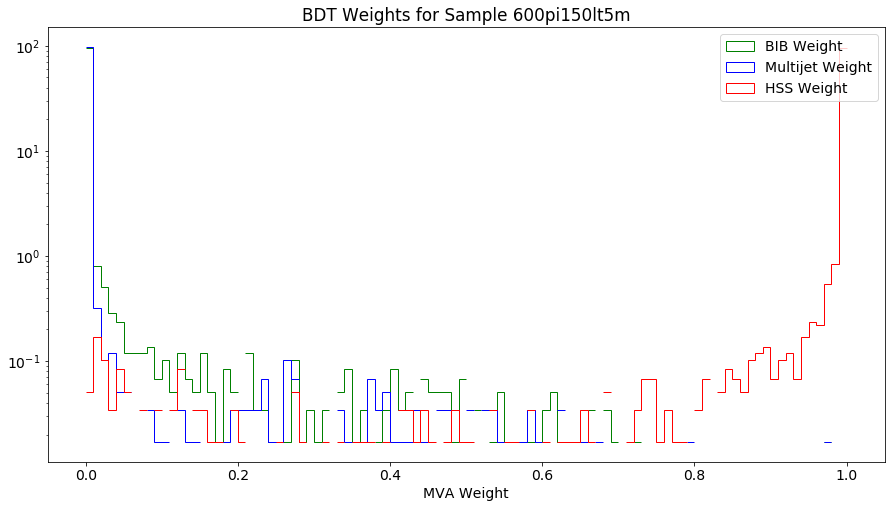

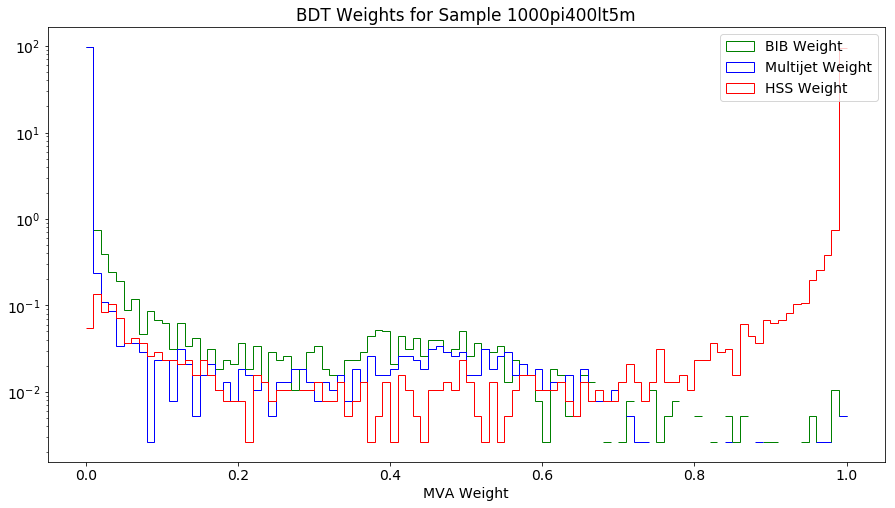

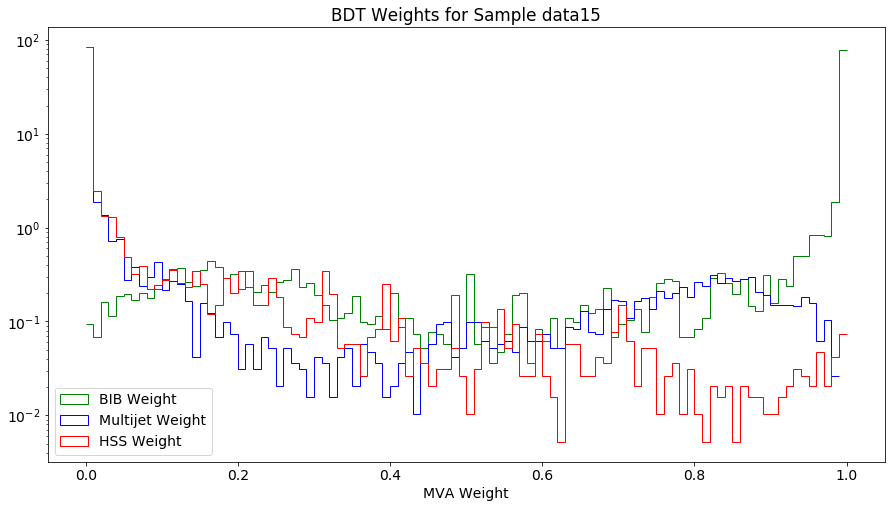

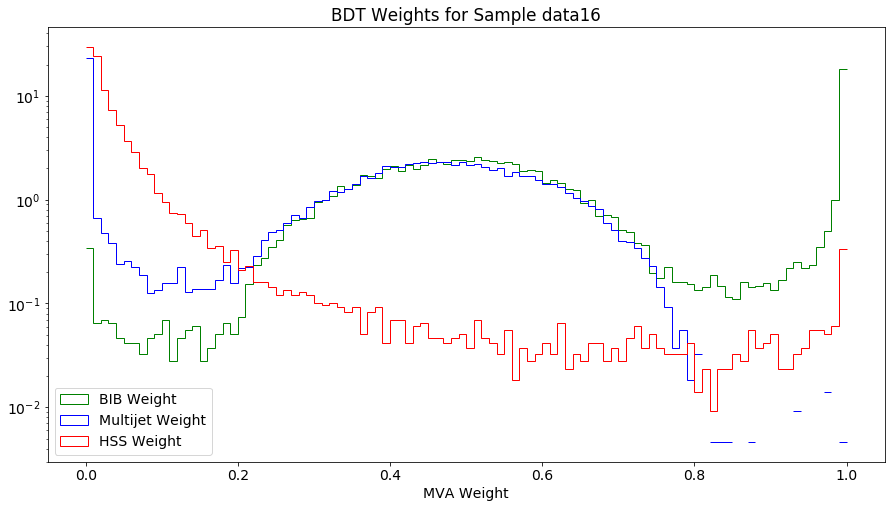

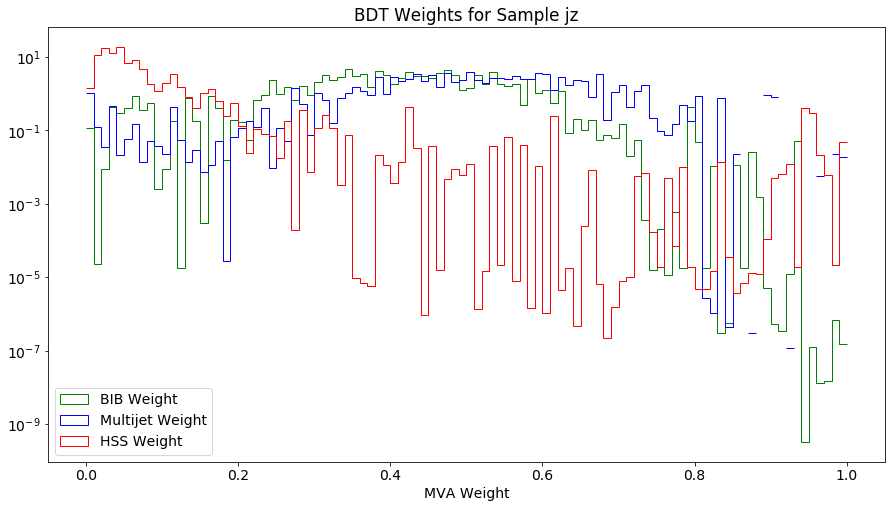

In [7]:
plot_mva_samples({**signal_samples, **bib_samples, **mj_samples})

What sizes are these datasets?

In [8]:
all = {**signal_samples, **bib_samples, **mj_samples}
{sname:len(all[sname].index) for sname in all}

{'1000pi400lt5m': 38019,
 '125pi25lt5m': 52921,
 '200pi25lt5m': 97196,
 '400pi50lt5m': 7835,
 '600pi150lt5m': 5896,
 'data15': 19247,
 'data16': 21591,
 'jz': 50000}

A plot of MVA values where we take advantage of the fact that they all add up to 1.

In [9]:
def split_data_in_slices (sample, weight, divisions = 20):
    '''Split a sample up along a given axis. In each bin calculate the average
    
    Args:
        sample  -  The sample DataFrame we are going to split
        weight - Name of weight axis to split by
        divisions - How many equal sized bins to split this into
    
    Returns:
        DataFrame with rows labeled by the lower edge of the sliced bin, and average
        weight for HSS, MultiJet, and BIB, and a column with the # of events in each bin.
    '''
    s = sample.drop('Weight', axis=1)
    pdiv = 1.0/divisions
    slice_edges = [(b*pdiv, pdiv*(b+1)) for b in range(divisions)]

    mean_evolution = {se[0]:s[(s[weight] >= se[0]) & (s[weight] < se[1])].mean() for se in slice_edges}
    count = {se[0]:len(s[(s[weight] >= se[0]) & (s[weight] < se[1])].index) for se in slice_edges}

    me = pd.DataFrame(mean_evolution).T
    me['SliceCount']=pd.Series(list(count.values()), index=me.index)
    return me

def split_data_in_slices_for_all (samples, weight, divisions = 20):
    '''Split all the samples in the dict samples
    
    Args
        samples - dict of all samples
        weight - Name of weight axis to split along
        divisions - how many equal bins to split things into
        
    Return
        Dict of results
    '''
    return {name:split_data_in_slices(samples[name],weight,divisions) for name in samples}

In [10]:
slc = split_data_in_slices(mj_samples["jz"], 'MultijetWeight')
slc

,RunNumber,EventNumber,HSSWeight,MultijetWeight,BIBWeight,SliceCount
0.00,284500.0,2.821847e+06,0.693932,0.013843,0.292225,1408
0.05,284500.0,3.034737e+06,0.422922,0.071645,0.505434,443
0.10,284500.0,3.088260e+06,0.355783,0.126405,0.517812,302
0.15,284500.0,3.270846e+06,0.251014,0.176152,0.572833,380
0.20,284500.0,2.876628e+06,0.160134,0.226879,0.612987,669
0.25,284500.0,3.160970e+06,0.106697,0.278023,0.615281,1341
0.30,284500.0,3.158528e+06,0.074084,0.327376,0.598540,2483
0.35,284500.0,3.524467e+06,0.085144,0.380678,0.534178,5741
0.40,284500.0,3.303819e+06,0.053935,0.425040,0.521025,6000
0.45,284500.0,3.229387e+06,0.040976,0.475277,0.483747,6485


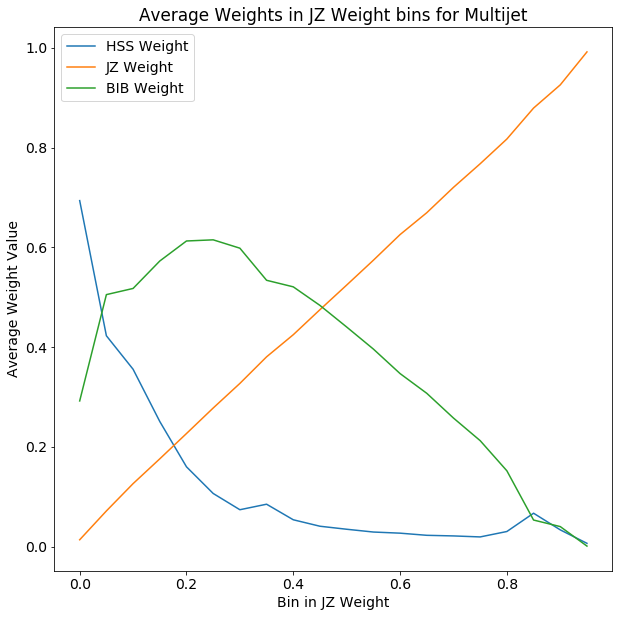

In [11]:
def plot_average_weights (sample, sample_name, slice_weight_name):
    '''Plot the slice data for a particular sample
    
    Args
        sample - slice data for the sample
        sample_name - the name of the sample we will put on plot
        weight_name - the weight name that was used to slice everything
        
    Returns
        Plot drawn on the current figure.
    '''
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(sample.index, sample['HSSWeight'], label='HSS Weight')
    ax.plot(sample.index, sample['MultijetWeight'], label='JZ Weight')
    ax.plot(sample.index, sample['BIBWeight'], label="BIB Weight")
    ax.set_xlabel('Bin in {0}'.format(slice_weight_name))
    ax.set_ylabel('Average Weight Value')
    ax.set_title('Average Weights in {0} bins for {1}'.format(slice_weight_name, sample_name))
    plt.legend()

plot_average_weights(slc, "Multijet", "JZ Weight")
plt.show()

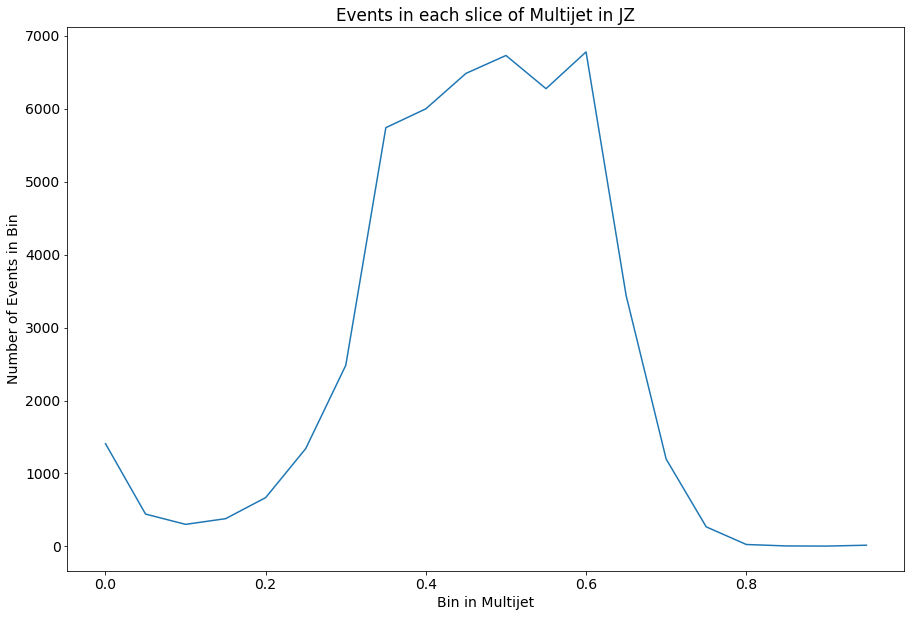

In [12]:
def plot_slice_sizes (sample, sample_name, slice_weight_name):
    '''Plot the number of events in each slice
    
    Args
        sample - Slice data for a sample
        sample_name - name of the sample for plot title
        slice_weight_name - name of weight that that is used to slice
        
    Returns
        Default plot of the number of events
    '''
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.plot(sample.index, sample.SliceCount)
    ax.set_xlabel('Bin in {0}'.format(slice_weight_name))
    ax.set_ylabel('Number of Events in Bin')
    ax.set_title('Events in each slice of {0} in {1}'.format(slice_weight_name, sample_name))

plot_slice_sizes(slc, 'JZ', 'Multijet')
plt.show()

## 3D Scatter Plots

Plotting a full 3D scatter plot is very time consuming! It takes more than 5 minutes on my computer. So becareful executing through this guy.

In [13]:
def plot_mva_scatter_plot (sample_name, signal_data, bib_data, background_data):
    """Plot the results as a scatter plot for """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    args = {'marker': '.'}
    
    ax.scatter(signal_data[" HSSWeight"], signal_data[" MultijetWeight"], signal_data[" BIBWeight"], color='b', **args)
    ax.scatter(bib_data[" HSSWeight"], bib_data[" MultijetWeight"], bib_data[" BIBWeight"], color='g', **args)
    ax.scatter(background_data[" HSSWeight"], background_data[" MultijetWeight"], background_data[" BIBWeight"], color='r', **args)
    ax.set_xlabel('HSS')
    ax.set_ylabel('Multijet')
    ax.set_zlabel('BIB')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_zlim([0.0, 1.0])
    plt.show()

In [14]:
#plot_mva_scatter_plot("dude", signal_samples["125pi25lt5m"], bib_samples["data15"], mj_samples["jz"])

## ROC Curves

Look at ROC curves as a function of BIB cut.

These are mutli-class results - so w_hss + w_mj + w_bib = 1.0. Yet for the ROC curve we have to look at a single weight.

In [15]:
def roc_curve_calc(signal, background, weight='HSSWeight'):
    '''Calculate a ROC curve
    
    Args:
        signal - data frame that contains the signal
        background - data frame that contains teh background
        weight - the column in the DataFrame that we pull the weights from
        
    Returns
        tpr - true positive rate
        fpr - false postive rate
        auc - Area under the curve for the tpr/fpr curve - bigger is better!
    '''
    # build a single array marking one as signal and the other as background
    truth = np.concatenate((np.ones(len(signal.index)), np.zeros(len(background.index))))
    score = np.concatenate((signal[weight], background[weight]))
    (fpr, tpr, thresholds) = roc_curve(truth,score)
    
    a = auc(fpr, tpr)
    
    return (tpr, fpr, a)

def plot_roc_curve (tpr, fpr, aroc, signal_name = 'Signal', background_name = 'JZ'):
    '''Plot a ROC curve
    
    Args:
        tpr - True positive rate
        fpr = False postiive rate
        aroc - the area under the curve (in the legend)
        signal_name - for the signal axis label
        background_name - for the background axis name
    '''
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange', label='ROC Curve area {0:0.2f}'.format(aroc))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('{0} Positive Rate'.format(signal_name))
    plt.xlabel('{0} Postiive Rate'.format(background_name))
    plt.legend()

In [16]:
tpr, fpr, aroc = roc_curve_calc(signal_samples["125pi25lt5m"], mj_samples["jz"])

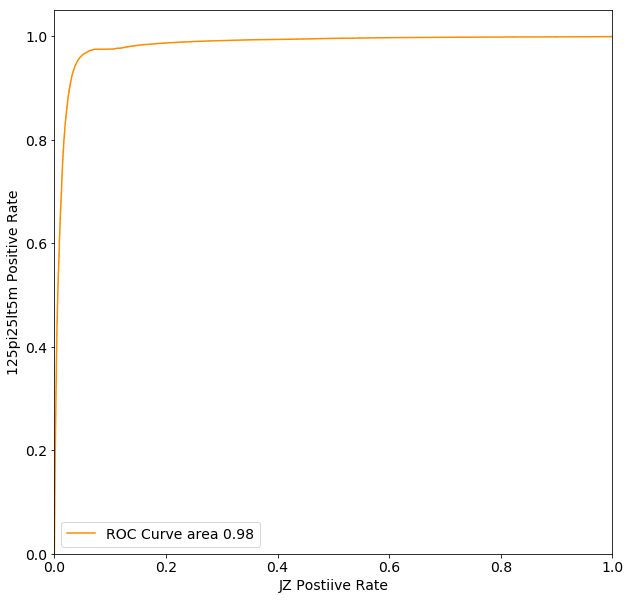

In [17]:
plot_roc_curve(tpr, fpr, aroc, signal_name = "125pi25lt5m")
plt.show()

In [18]:
def calc_roc_with_bib_cut (sig, back, bib, bib_cut = 0.5):
    '''Calc ROC curve basics after limiting the data sample for a particular bib cut
    
    Args:
        sig - signal DataFrame
        back - background DataFrame
        bib - the bib sample
        bib_cut - only events with a bib value less than this number will be included
        
    Returns:
        tpr - true positive rate
        fpr - false positive rate
        aroc - area under the ROC curve
        sig_eff - How much signal this bib cut removed
        back_eff - how much background this bib cut removed
        bib_eff
    '''
    gsig = sig[sig['BIBWeight']<bib_cut]
    sig_eff = len(gsig.index)/len(sig.index)
    gback = back[back['BIBWeight']<bib_cut]
    back_eff = len(gback.index)/len(back.index)
    gbib = bib[bib['BIBWeight']<bib_cut]
    bib_eff = len(gbib.index)/len(bib.index)
    
    tpr, fpr, aroc = roc_curve_calc(gsig, gback)
    
    return (tpr, fpr, aroc, sig_eff, back_eff, bib_eff)

def calc_roc_family (sig, back, bib, bib_cut_range = np.logspace(-3,0,30)):
    '''Calc ROC Curve for a family of bib cuts
    
    Args:
        sig - signal DataFrame
        back - background (jz) DataFrame
        bib - bib DataFrame
        bib_cut_range - Value of bib efficiencies to look at. Actual cuts are determined from this

    Returns:
        all - DataFrame of truth and false postive rate, area under curve, sig, back, and bib eff, and the bib cut
    '''
    sorted_bib_values = bib['BIBWeight'].sort_values()
    lst_len = len(sorted_bib_values.index)-1
    bib_cut_values = [sorted_bib_values.values[index] for index in [int(lst_len*cut_fraction) for cut_fraction in bib_cut_range]]
    all = [calc_roc_with_bib_cut (sig, back, bib, bib_cut = bc)+(bc,) for bc in bib_cut_values]
    return pd.DataFrame(all, columns=['tpr', 'fpr', 'aroc', 'sig_eff', 'back_eff', 'bib_eff', 'bib_cut'])

In [19]:
p125 = calc_roc_family(signal_samples["125pi25lt5m"], mj_samples["jz"], bib_samples['data15'])

In [20]:
p125

,tpr,fpr,aroc,sig_eff,back_eff,bib_eff,bib_cut
0,"[0.0, 0.0618951508565, 0.0720902551364, 0.0786...","[0.0, 0.0493273542601, 0.0582959641256, 0.0717...",0.612497,0.365129,0.00446,0.000987,0.011307
1,"[0.0, 0.0560949298813, 0.0653346465926, 0.0712...","[0.0, 0.0441767068273, 0.0522088353414, 0.0642...",0.609973,0.402884,0.00498,0.001247,0.015184
2,"[0.0, 0.0514851485149, 0.0599655617736, 0.0654...","[0.0, 0.0391459074733, 0.0462633451957, 0.0569...",0.615371,0.438956,0.00562,0.001559,0.019836
3,"[0.0, 0.0489281623302, 0.0569873997709, 0.0621...","[0.0, 0.0359477124183, 0.0424836601307, 0.0522...",0.623357,0.461896,0.00612,0.002026,0.023336
4,"[0.0, 0.0466495046415, 0.0543334113425, 0.0592...","[0.0, 0.0333333333333, 0.0393939393939, 0.0484...",0.627616,0.484458,0.00660,0.002546,0.027339
5,"[0.0, 0.0447002541486, 0.052063088653, 0.05680...","[0.0, 0.030985915493, 0.0366197183099, 0.04507...",0.632677,0.505584,0.00710,0.003273,0.031576
6,"[0.0, 0.0420430976904, 0.0489682567582, 0.0534...","[0.0, 0.0269607843137, 0.031862745098, 0.03921...",0.649809,0.537537,0.00816,0.004156,0.038943
7,"[0.0, 0.0402978537013, 0.0469355436504, 0.0512...","[0.0, 0.0248868778281, 0.0294117647059, 0.0361...",0.655118,0.560817,0.00884,0.005248,0.045032
8,"[0.0, 0.0385980765507, 0.0449557864842, 0.0490...","[0.0, 0.0225872689938, 0.0266940451745, 0.0328...",0.663864,0.585514,0.00974,0.006702,0.052740
9,"[0.0, 0.0368635186783, 0.0429355196647, 0.0468...","[0.0, 0.0209523809524, 0.0247619047619, 0.0304...",0.663541,0.613065,0.01050,0.008521,0.062439


In [21]:
p_samples = {sname:calc_roc_family(signal_samples[sname], mj_samples["jz"], bib_samples['data15']) for sname in signal_samples.keys()}

Lets look at the eff plot for all samples as a function of the bib cut

In [22]:
def plot_eff_for_bib(ps, sample_name):
    '''Plot the Efficiency plots for a single sample
    
    Args:
        ps - DataFrame of the sample we will look at
        sample_name - Name of sample
    '''
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.plot(ps.bib_eff,ps.sig_eff, label='Sample {0}'.format(sample_name))
    plt.plot(ps.bib_eff,ps.back_eff, label='Sample JZ')
    plt.plot(ps.bib_eff,ps.bib_eff, label='Sample BIB')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.001, 1.0])
    plt.xlabel('BIB Fraction')
    plt.ylabel('Fraction of Events')
    ax.set_xscale('log')
    plt.grid(alpha=0.5, which='both')
    plt.title('{0}, JZ, and BIB Efficiencies as a function of BIB Fraction'.format(sample_name))
    plt.legend()

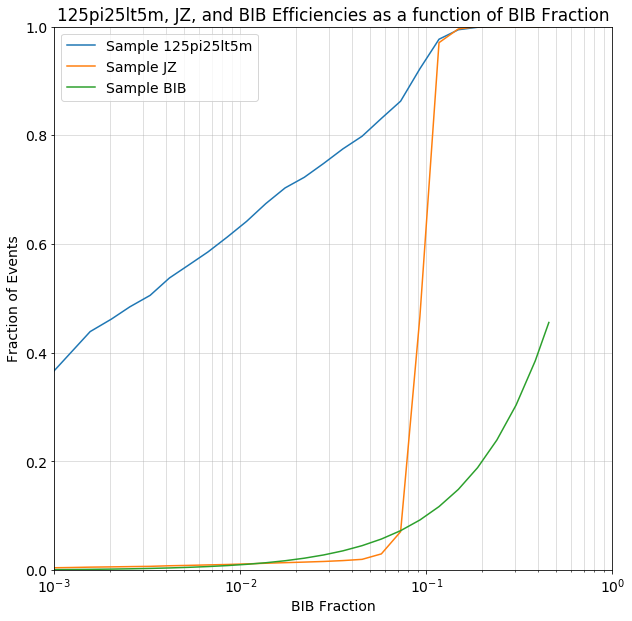

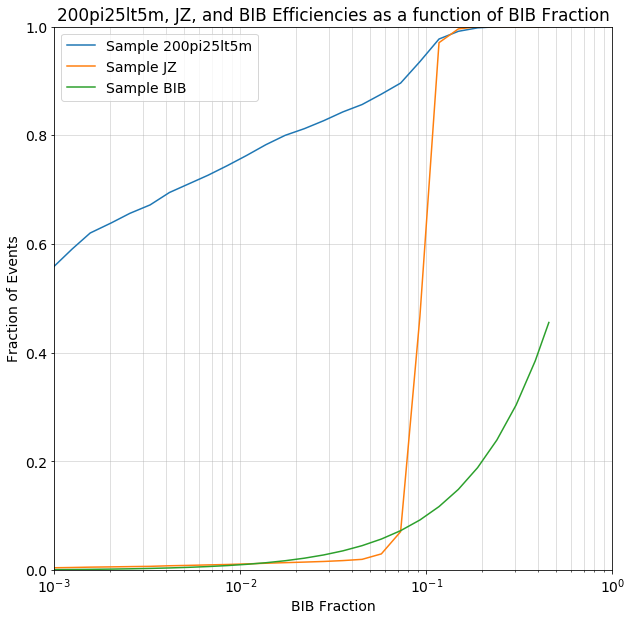

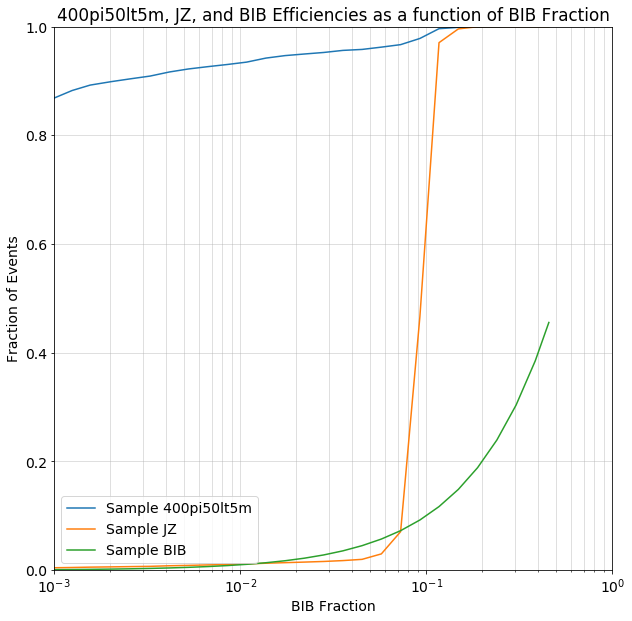

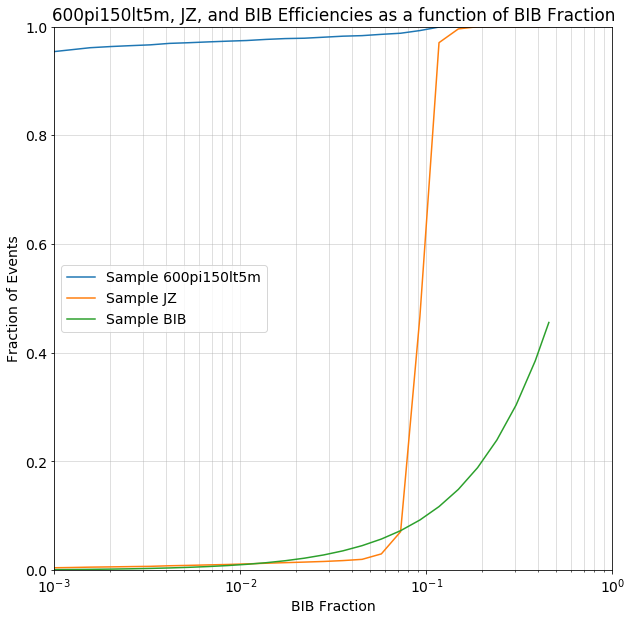

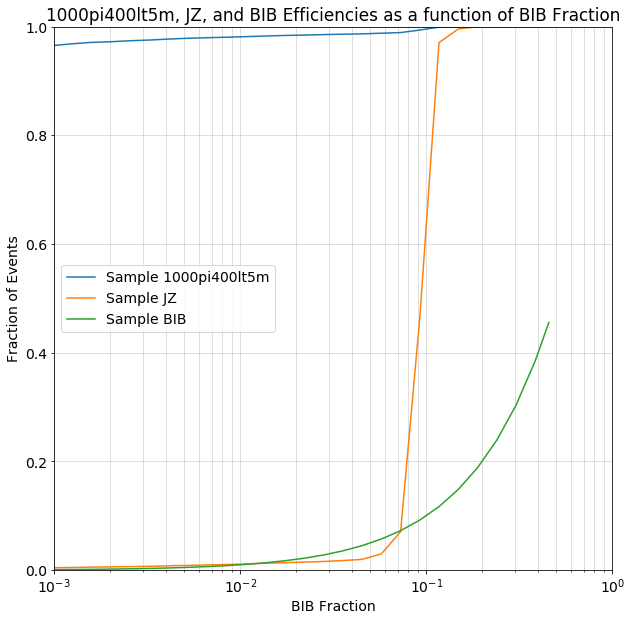

In [23]:
for sname in p_samples.keys():
    plot_eff_for_bib(p_samples[sname], sname)
    plt.show()

Try plotting the family of signal efficencies on the same plot

In [24]:
def plot_all_eff_for_bib(samples):
    '''Plot the efficiency plots for all samples and JZ and BIB
    
    Args
        samples - The df containing all singal samples ROC calculations with eff loaded
    '''
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    # Do the eff samples
    for s in samples:
        plt.plot(samples[s].bib_eff,samples[s].sig_eff, label='Sample {0}'.format(s))
    # Do the background
    abck=samples[list(samples.keys())[0]]
    plt.plot(abck.bib_eff,abck.back_eff, label='Sample JZ')
    plt.plot(abck.bib_eff,abck.bib_eff, label='Sample BIB')
    # Get the plot in shape
    plt.ylim([0.0, 1.0])
    plt.xlim([0.001, 1.0])
    plt.xlabel('BIB Fraction')
    plt.ylabel('Fraction of Events')
    plt.title('Signal, JZ, and BIB Efficiencies as a function of BIB Fraction')
    ax.set_xscale('log')
    plt.legend()

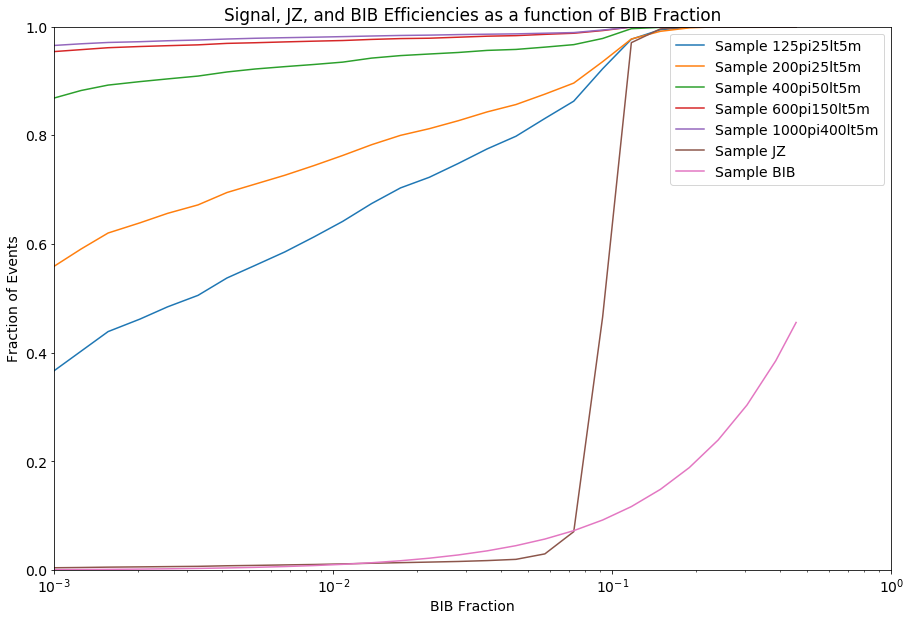

In [25]:
plot_all_eff_for_bib(p_samples)
plt.show()

Look at a faimly of ROC plots now, for each BIB cut

In [26]:
def plot_roc_family_sample(sample_info_bib, sample_name, background_name = 'JZ', nsamples=10):
    '''Plot a family of scaled ROC curves
    
    Args:
        sample_info_bib - Each row has a DF containing info on each bib cut point
        sample_name - Name of the sample (for plot title)
        background_name - Name of the background samples (JZ usually)
        nsamples - sample the list of bib cuts (if there are too many)
        
    Returns
        None
        But matplotlib will be sitting at a plot
    '''
    resample = 1
    if nsamples <= len(sample_info_bib.index):
        resample = int(len(sample_info_bib.index)/nsamples)
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(111)
    for index,r in sample_info_bib.iloc[::-resample].iterrows():
        sig_scale = r.sig_eff
        back_scale = r.back_eff
        ax.plot(r.fpr*back_scale, r.tpr*sig_scale, label='BIB Cut {0:0.4f} eff={1:0.3f} (AROC={2:0.3f})'.format(r.bib_cut, r.bib_eff, r.aroc))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('{0} Positive Rate'.format(sample_name))
    plt.xlabel('{0} Postiive Rate'.format(background_name))
    plt.title('ROC curves for {0} as a function of BIB cut'.format(sample_name))
    plt.legend()

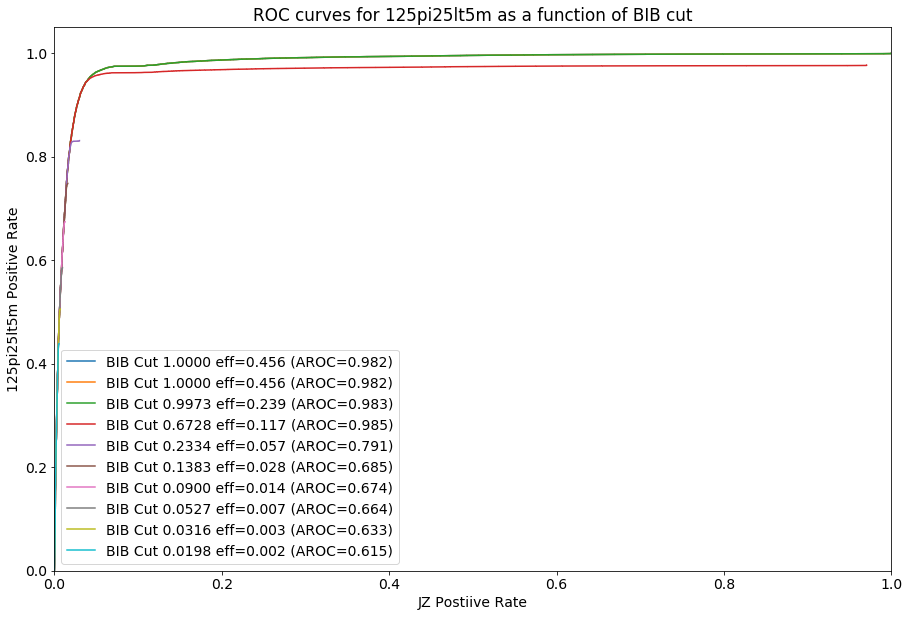

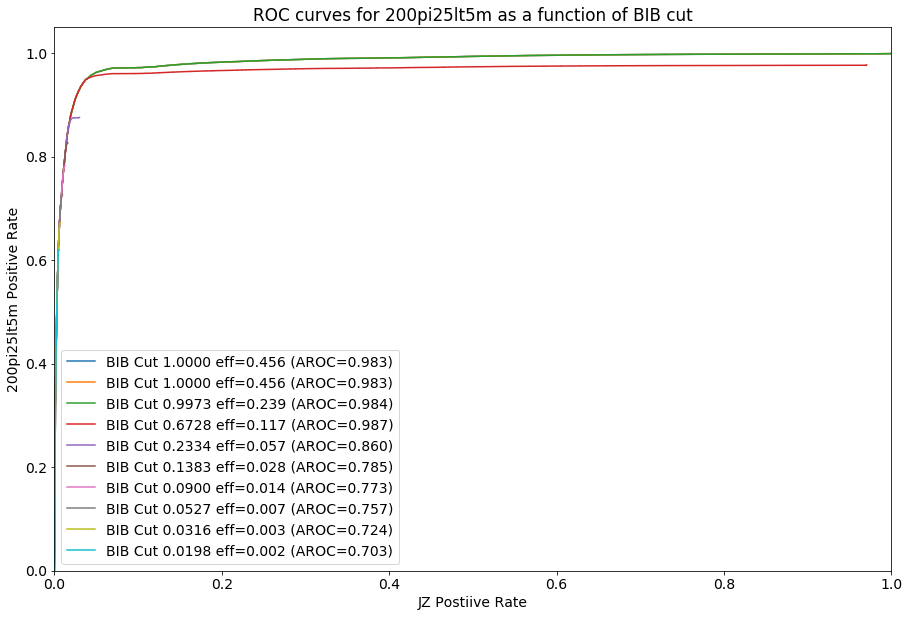

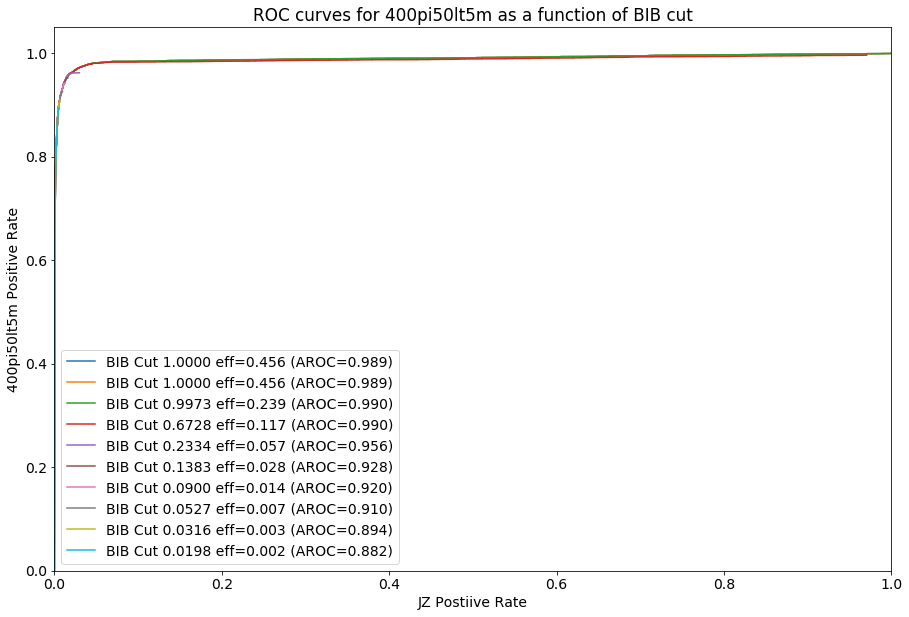

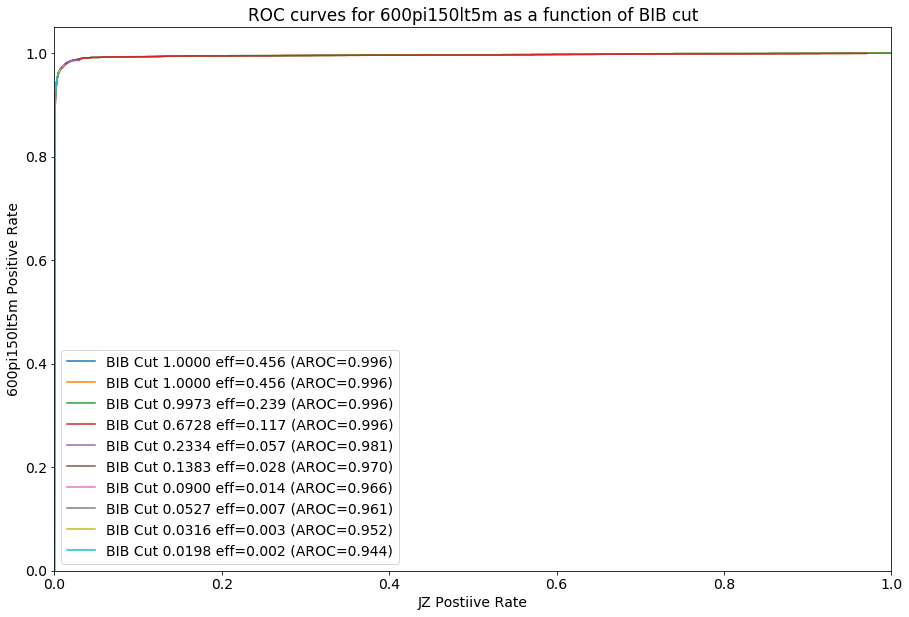

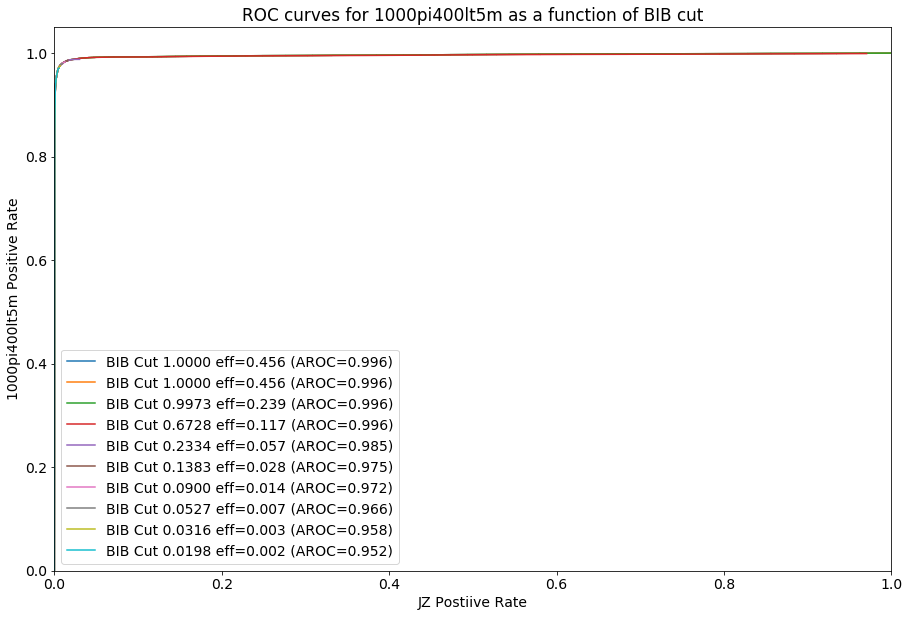

In [27]:
for sname in p_samples.keys():
    plot_roc_family_sample(p_samples[sname], sname)
    plt.show()